In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from models import Generator, Discriminator
from training_functions import train_gan
from helper_functions import Evaluator, visualize_reconstructions, generate_images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Wczytanie danych

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_path = "./trafic_32"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

labels = dataset.classes
print("Number of labels:", len(dataset.classes))

Number of labels: 43


In [3]:
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True, num_workers=4)

## Podstawowy model

In [4]:
latent_dim = 32
img_dim = 3*32*32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=img_dim, image_shape=[3, 32, 32]).to(device)
discriminator = Discriminator(input_dim=img_dim, hidden_dim=256).to(device)

In [5]:
evaluator = Evaluator(img_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [6]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
criterion = nn.MSELoss()
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
train_G_hist, train_D_hist, eval_G_hist, D_fake_acc_hist, D_real_acc_hist = train_gan(generator, discriminator, train_loader, val_set[0], val_loader, generator_optimizer, discriminator_optimizer, criterion, device, evaluator.evaluate)

100%|██████████| 10/10 [07:54<00:00, 47.49s/it]


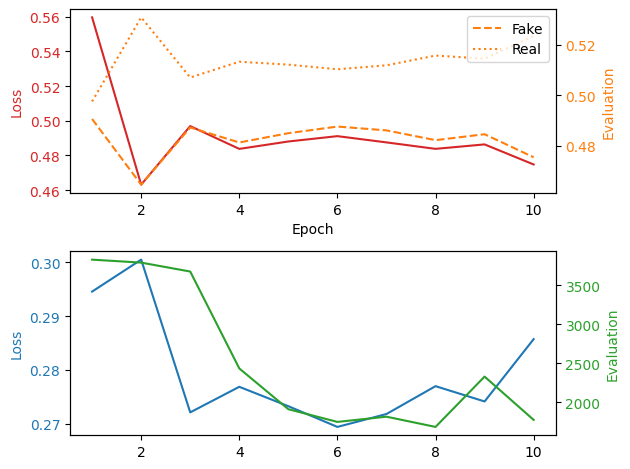

In [7]:
fig, axs = plt.subplots(2)
iters = np.arange(1, 11)
color_D_loss = "tab:red"
color_D_eval = "tab:orange"
color_G_loss = "tab:blue"
color_G_eval = "tab:green"
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color=color_D_loss)
axs[0].plot(iters, train_D_hist, color=color_D_loss)
axs[0].tick_params(axis='y', labelcolor=color_D_loss)
ax2 = axs[0].twinx()
ax2.set_ylabel('Evaluation', color=color_D_eval)
ax2.plot(iters, D_fake_acc_hist, color=color_D_eval, linestyle='dashed', label='Fake')
ax2.plot(iters, D_real_acc_hist, color=color_D_eval, linestyle='dotted', label='Real')
ax2.tick_params(axis='y', labelcolor=color_D_eval)
ax2.legend(loc='upper right')

axs[1].set_ylabel('Loss', color=color_G_loss)
axs[1].plot(iters, train_G_hist, color=color_G_loss)
axs[1].tick_params(axis='y', labelcolor=color_G_loss)
ax3 = axs[1].twinx()
ax3.set_ylabel('Evaluation', color=color_G_eval)
ax3.plot(iters, eval_G_hist, color=color_G_eval, linestyle='solid')
ax3.tick_params(axis='y', labelcolor=color_G_eval)

fig.tight_layout()
plt.show()

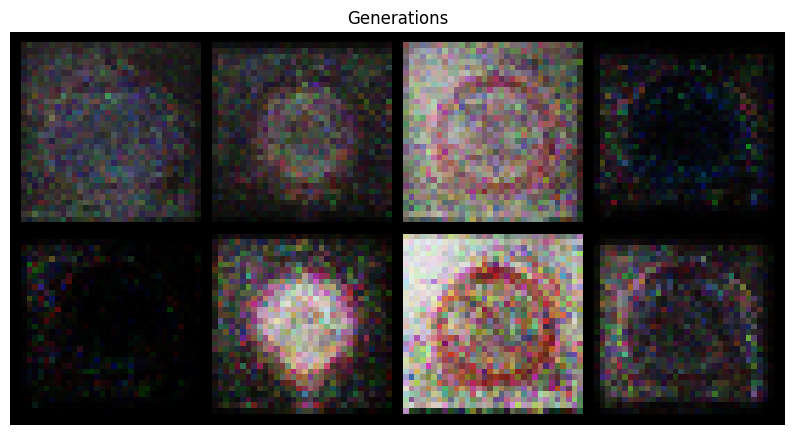

In [8]:
generate_images(generator, 8, device)